<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=10>Data Science and Business Analytics</center></font></h1>
<h1><center>Ensemble Techniques: Boosting - Week 2</center></h1>


<center><img src="https://images.pexels.com/photos/6280594/pexels-photo-6280594.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" width="800" height="500"></center>

<b><h2><center>Bike Sharing Case Study</center></h2></b>

## Problem Statement

### Context:

Bike-sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return has become automatic. Through these systems, the user can easily rent a bike from a particular position and return to another position. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 500 thousand bicycles. Today, there exists a great interest in these systems due to their important role in traffic, environmental, and health issues.


### Objective:
'Travel Along' is a new bike-sharing company and wants to expand its customer count and provide better services at a reasonable cost. They have conducted several surveys and collated the data about weather, weekends, holidays, etc. from the past 2 years.

As a recently hired data scientist at 'Travel Along', you have been asked to analyze the patterns in the data and figure out the key areas which can help the organization to grow and manage the customer demands. Further, you need to use this information to predict the count of bikes shared so that the company can take prior decisions for surge hours.
- What are the different factors which affect the target variable? What business recommendations can we give based on the analysis?
- How can we use different ensemble techniques - Bagging, Boosting, and Stacking to build a model to predict the count of bikes rented?

### Data Description:

The bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, the day of week, season, the hour of the day, etc. can affect the rental behaviors.

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : whether the day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday then 1, otherwise is 0.
- weathersit :
	- 1: Clear, Few clouds, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided by 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max). The “feel like” temperature relies on environmental data including the ambient air temperature, relative humidity, and wind speed to determine how weather conditions feel to bare skin.
- hum: Normalized humidity. The values are divided by 100 (max)
- windspeed: Normalized wind speed. The values are divided by 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Importing necessary libraries

**Let's start by importing libraries we need.**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split

## Reading the dataset

In [ ]:
#Loading dataset
data=pd.read_csv("hour.csv")

## Overview of the dataset

### View the first 5 rows of the dataset

In [ ]:
data.head()

### Check data types and number of non-null values for each column

In [ ]:
data.info()

- We can see that there are total of 17 columns and 17,379 rows in the dataset.
- All columns' data type is either integer or float except one column - 'dteday' which is of the object type.
- The number of non-null values of each column is equal to the number of total rows in the dataset i.e. no null value. We can further confirm this using `isna()` method.

In [ ]:
data.isna().sum()

- There are no missing values in the data.

### Summary of the dataset

In [ ]:
# Summary of continuous columns
data[['temp','atemp','hum','windspeed','cnt']].describe().T

- The mean and median value of temperature is approx 0.50
- The mean and median value for 'atemp' is approx 0.47 and 0.48 respectively
- The mean and median value for 'hum' is approx 0.627 and 0.63 respectively
- Wind speed has some extreme values at the right end
- The target variable seems to have skewed distribution as higher values are on the right. We will explore this further.

### Number of unique values in each column

In [ ]:
data.nunique()

- We can drop 'instant' column as it is an ID variable and will not add value to the model.
- We can drop 'dteday' column as it just contains dates of 731 days i.e. 2 years. This will not add value to the model.

In [ ]:
#Dropping two columns from the dataframe
data.drop(columns=['instant','dteday'], inplace=True)

### Number of observations in each category

In [ ]:
cat_cols=['season','yr','holiday','workingday','weathersit']

for column in cat_cols:
    print(data[column].value_counts())
    print('-'*30)

- The number of observations from year 0 i.e. 2011 is slightly more than the number of observations from year 1 i.e. 2012.
- As expected, the number of non-holidays and working days are much higher than the number of holidays and non-working days respectively.
- We have only 3 observations where weathersit=4 and most common is 1 i.e. clear or partly cloudy.

In [ ]:
df = data.copy()

## <a name='link2'>Exploratory Data Analysis (EDA) Summary</a>

### **Note**: The EDA section has been covered multiple times in the previous case studies. In this case study, we will mainly focus on the model building aspects. We will only be looking at the key observations from EDA. The detailed EDA can be found in the <a href = #link1>appendix section</a>.

**The below functions need to be defined to carry out the EDA.**

In [ ]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate analysis

In [ ]:
histogram_boxplot(data,'windspeed')

- Wind speed has a right-skewed distribution and 0 has the highest count among all observations
- Distribution is not symmetric but mean and median are approx equal with a value equal to 0.19
- There are many outliers in this variable

In [ ]:
histogram_boxplot(data,'cnt')

In [ ]:
#Top 5 highest values
data['cnt'].nlargest()

- The target variable i.e. the count of bikes rented has a right-skewed distribution
- The range of values is very large with many observations being less than 10 counts and some being greater than 900 count
- As evident from the boxplot, there are many outliers

In [ ]:
labeled_barplot(data,'weathersit',perc=True)

- Season 1 has the highest percentage of observations i.e. 65.7%
- Season 2 and season 3 have 26.1% and 8.2% observations respectively
- We saw earlier that season 4 has only 3 observations in the data. Here, it shows 0% observations due to rounding off.

In [ ]:
labeled_barplot(data,'workingday',perc=True)

- As expected, the number of observations for working days is higher than the number of observations for non-working days.
- There are approx 68% observations for working days and 32% observations for non-working days.

### Bivariate analysis

**Correlation Check**

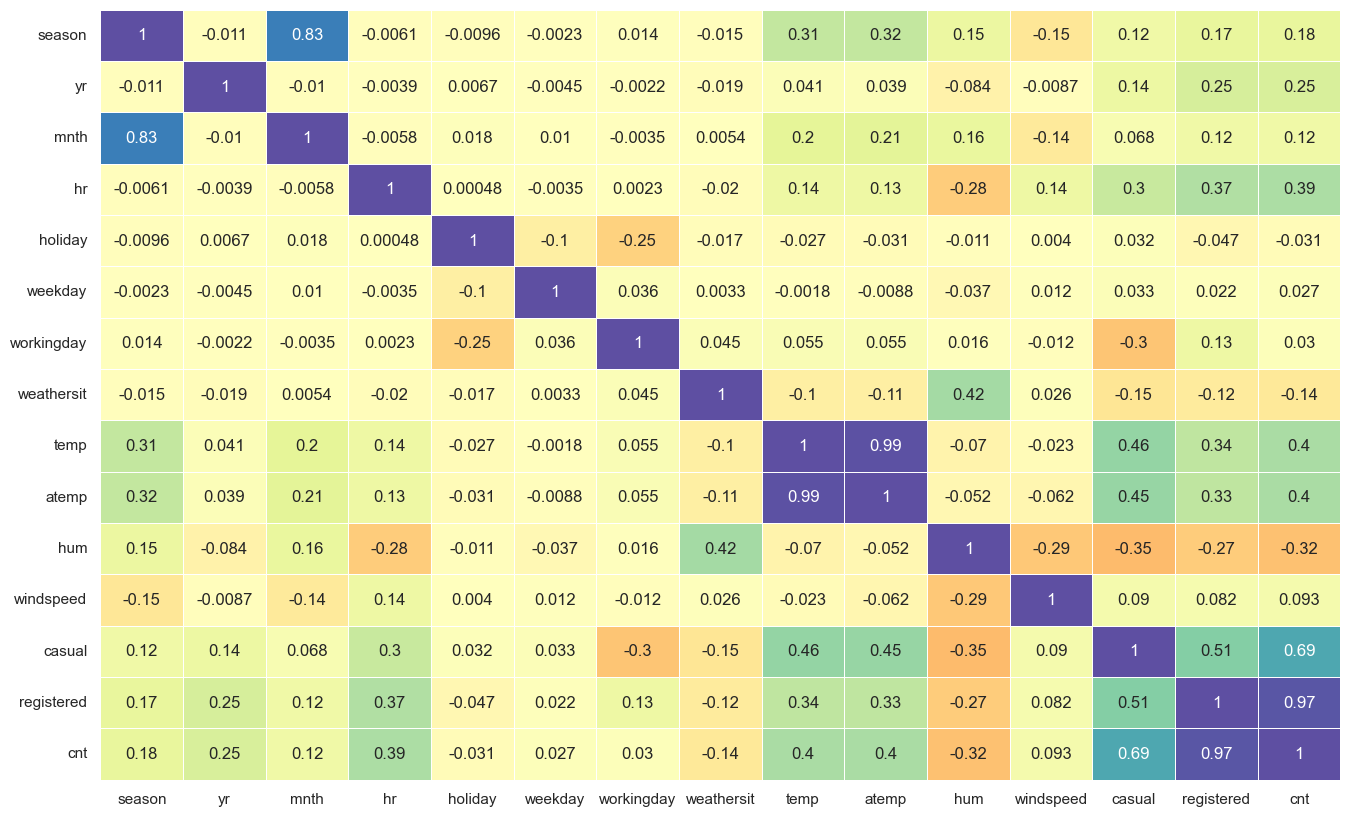

In [18]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(data.corr(numeric_only=True),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

- We can see that temperature and feel like temperature are almost perfectly correlated
- Month and season have a high positive correlation among them
- As count is the addition of two columns - Casual and registered. We can drop these two columns because if we have casual and registered count then making a model won't make sense as we can simply add them. We would not have these 2 columns while predicting new observations

In [ ]:
sns.set(rc={'figure.figsize':(21,7)})
sns.catplot(x=data["season"], y=data["cnt"], kind="swarm",height=7, aspect=3);

- The lowest number of bikes are rented in the first season
- The highest number of bikes are shared in 3rd season
- This can be due to the relatively high temperature in season 1 i.e. spring as compared to season 3 i.e. fall

In [ ]:
sns.set(rc={'figure.figsize':(21,7)})
sns.catplot(x=data["weekday"], y=data["cnt"], kind="swarm", height=7, aspect=3);

- Weekends i.e. weekday=0 and weekday=6 have a low count of bikes rented and it is less varying.
- Working days have a higher count of bikes rented and have more variation in the count and there are some outliers for days from 1 to 5.
- This can be due to closed schools/offices on weekends.

In [ ]:
sns.catplot(x=data["hr"], y=data["cnt"], kind='bar', height=7, aspect=1.5, estimator=np.mean);

- We can see the average number of bikes rented is high at 8 AM and 5-6 PM, this can be due to office/school/college timings.
- The average number of bikes rented is very low for night time i.e. 12 AM to 5 AM.

In [ ]:
sns.catplot(x=data["mnth"], y=data["cnt"], kind='bar', height=6, aspect=1.6, estimator=np.mean);

- The average number of bikes rented is low for months - December, January, February. This can be due to the cold weather in these months.
- The average number of bikes rented is consistently high for months from May to October.

In [ ]:
sns.set(rc={'figure.figsize':(15,7)})
pd.pivot_table(data=data, index=['yr', 'season'], values='cnt', aggfunc=np.sum).plot(kind='bar');

- We can see that number of bikes rented is higher in the year 2012 for each season as compared to seasons in 2011.
- This shows that bike-sharing is becoming more popular with time.

In [ ]:
sns.catplot(x=data["weathersit"], y=data['cnt'], kind='bar', height=6, aspect=1.25, estimator=np.mean);

- As expected, the average count of bikes rented is much higher on clear or partly cloudy days compared to snowy or rainy days.
- This implies that the average count of bikes rented is hugely affected by the weather.

## Data Preprocessing

### Outlier Detection and Treatment

In [ ]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- There are quite a few outliers in the data.
- However, we will not treat them as they are proper values.

**Actions for data pre-processing:**

* As count is the addition of two columns - Casual and registered, we can drop these two columns because if we have casual and registered count then making a model won't make sense as we can simply add them.

* We would not have these 2 columns while predicting new observations

In [ ]:
#Dropping columns - casual and registered
data.drop(columns=['casual','registered'], inplace=True)

### Data Preparataion for model building

In [ ]:
# Separating features and the target column
X = data.drop('cnt', axis=1)
y = data['cnt']

In [ ]:
# Splitting the data into train and test sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)

In [ ]:
X_train.shape, X_test.shape

- We have 12,165 observations in the train set and 5,214 observations in the test set.

## Bagging - Model Building and Hyperparameter Tuning

- We'll fit different models on the train data and observe their performance.
- We'll try to improve that performance by tuning some hyperparameters available for that algorithm.
- We'll use GridSearchCv for hyperparameter tuning and `r_2 score` to optimize the model.
- R-square - `Coefficient of determination` is used to evaluate the performance of a regression model. It is the amount of the variation in the output dependent attribute which is predictable from the input independent variables.
- Let's start by creating a function to get model scores, so that we don't have to use the same codes repeatedly.

In [ ]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [ ]:
##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[]

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))

    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))

    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True:
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))

    # returning the list with train and test scores
    return score_list

### Decision Tree Model

In [ ]:
dtree=DecisionTreeRegressor(random_state=1)
dtree.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
dtree_model_train_perf=model_performance_regression(dtree, X_train,y_train)
print("Training performance \n",dtree_model_train_perf)

In [ ]:
dtree_model_test_perf=model_performance_regression(dtree, X_test,y_test)
print("Testing performance \n",dtree_model_test_perf)

- The Decision tree model with default parameters is overfitting the train data.
- Let's see if we can reduce overfitting and improve performance on test data by tuning hyperparameters.

### Hyperparameter Tuning

In [ ]:
# Choose the type of classifier.
dtree_tuned = DecisionTreeRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': list(np.arange(2,20)) + [None],
              'min_samples_leaf': [1, 3, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10, 15] + [None],
              'min_impurity_decrease': [0.001, 0.01, 0.1, 0.0]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dtree_tuned.fit(X_train, y_train)

In [ ]:
dtree_tuned_model_train_perf = model_performance_regression(dtree_tuned, X_train,y_train)
print("Training performance \n",dtree_tuned_model_train_perf)

In [ ]:
dtree_tuned_model_test_perf = model_performance_regression(dtree_tuned, X_test,y_test)
print("Testing performance \n",dtree_tuned_model_test_perf)

- The overfitting is reduced after hyperparameter tuning and the test score has increased by approx 2%.
- RMSE is also reduced on test data and the model is generalizing better than the decision tree model with default parameters.

**Plotting the feature importance of each variable**

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(dtree_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

In [ ]:
feature_names = X_train.columns
importances = dtree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature, in addition to temp and yr, for tuned decision tree model

### Random Forest Model

In [ ]:
rf_estimator=RandomForestRegressor(random_state=1)
rf_estimator.fit(X_train,y_train)

In [ ]:
rf_estimator_model_train_perf = model_performance_regression(rf_estimator, X_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)

In [ ]:
rf_estimator_model_test_perf = model_performance_regression(rf_estimator, X_test,y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

- Random forest is giving a good r2 score of 94% on the test data but it is slightly overfitting the train data.
- Let's try to reduce this overfitting by hyperparameter tuning.

### Hyperparameter Tuning

In [ ]:
# Choose the type of classifier.
rf_tuned = RandomForestRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {
                'max_depth':[4, 6, 8, 10, None],
                'max_features': ['sqrt','log2',None],
                'n_estimators': [80, 90, 100, 110, 120]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train, y_train)

In [ ]:
rf_tuned_model_train_perf = model_performance_regression(rf_tuned, X_train, y_train)
print("Training performance \n",rf_tuned_model_train_perf)

In [ ]:
rf_tuned_model_test_perf = model_performance_regression(rf_tuned, X_test, y_test)
print("Testing performance \n",rf_tuned_model_test_perf)

- No significant change in the result. The result is almost the same before or after the hyperparameter tuning.

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(rf_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

In [ ]:
feature_names = X_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature, in addition to temp and yr, for the tuned random forest model.

## Boosting - Model Building and Hyperparameter Tuning

### AdaBoost Regressor

In [ ]:
ab_regressor=AdaBoostRegressor(random_state=1)
ab_regressor.fit(X_train,y_train)

In [ ]:
ab_regressor_model_train_perf = model_performance_regression(ab_regressor, X_train,y_train)
print("Training performance \n",ab_regressor_model_train_perf)

In [ ]:
ab_regressor_model_test_perf = model_performance_regression(ab_regressor, X_test,y_test)
print("Testing performance \n",ab_regressor_model_test_perf)

- AdaBoost is generalizing well but it is giving poor performance, in terms of r2 score as well as RMSE, as compared to the decision tree and random forest model.  

### Hyperparameter Tuning

In [ ]:
# Choose the type of classifier.
ab_tuned = AdaBoostRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(10,100,10),
              'learning_rate': [1, 0.1, 0.5, 0.01],
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(ab_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
ab_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
ab_tuned.fit(X_train, y_train)

In [ ]:
ab_tuned_model_train_perf = model_performance_regression(ab_tuned, X_train,y_train)
print("Training performance \n",ab_tuned_model_train_perf)

In [ ]:
ab_tuned_model_test_perf = model_performance_regression(ab_tuned, X_test,y_test)
print("Testing performance \n",ab_tuned_model_test_perf)

- We can see that there is no significant improvement in the model after hyperparameter tuning.

In [ ]:
# importance of features in the tree building

print(pd.DataFrame(ab_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

In [ ]:
feature_names = X_train.columns
importances = ab_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature here, followed by yr and atemp.

### Gradient Boosting Regressor

In [ ]:
gb_estimator=GradientBoostingRegressor(random_state=1)
gb_estimator.fit(X_train,y_train)

In [ ]:
gb_estimator_model_train_perf = model_performance_regression(gb_estimator, X_train,y_train)
print("Training performance \n",gb_estimator_model_train_perf)

In [ ]:
gb_estimator_model_test_perf = model_performance_regression(gb_estimator, X_test, y_test)
print("Testing performance \n",gb_estimator_model_test_perf)

- Gradient boosting is generalizing well and giving decent results but not as good as random forest.

### Hyperparameter Tuning

In [ ]:
# Choose the type of classifier.
gb_tuned = GradientBoostingRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(50,200,25),
              'subsample':[0.7,0.8,0.9,1],
              'max_features':[0.7,0.8,0.9,1],
              'max_depth':[3,5,7,10]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(gb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gb_tuned.fit(X_train, y_train)

In [ ]:
gb_tuned_model_train_perf = model_performance_regression(gb_tuned, X_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)

In [ ]:
gb_tuned_model_test_perf = model_performance_regression(gb_tuned, X_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)

- We can see that the model has improved significantly in terms of r2 score and RMSE.
- The r2 score has increased by approx 12% on the test data.
- RMSE has decreased by more than 30 for the test data.

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(gb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

In [ ]:
feature_names = X_train.columns
importances = gb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature
- temp, yr and workingday have almost equal importance

### XGBoost Regressor

In [ ]:
xgb_estimator=XGBRegressor(random_state=1, verbosity = 0)
xgb_estimator.fit(X_train,y_train)

In [ ]:
xgb_estimator_model_train_perf = model_performance_regression(xgb_estimator, X_train, y_train)
print("Training performance \n",xgb_estimator_model_train_perf)

In [ ]:
xgb_estimator_model_test_perf = model_performance_regression(xgb_estimator, X_test,y_test)
print("Testing performance \n",xgb_estimator_model_test_perf)

- XGBoost with default parameters is giving almost as good results as the tuned gradient boosting model.

### Hyperparameter Tuning

In [ ]:
# Choose the type of classifier.
xgb_tuned = XGBRegressor(random_state=1, verbosity = 0)

# Grid of parameters to choose from
parameters = {'n_estimators': [75,100,125,150],
              'subsample':[0.7, 0.8, 0.9, 1],
              'gamma':[0, 1, 3, 5],
              'colsample_bytree':[0.7, 0.8, 0.9, 1],
              'colsample_bylevel':[0.7, 0.8, 0.9, 1]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

In [ ]:
xgb_tuned_model_train_perf = model_performance_regression(xgb_tuned, X_train, y_train)
print("Training performance \n",xgb_tuned_model_train_perf)

In [ ]:
xgb_tuned_model_test_perf = model_performance_regression(xgb_tuned, X_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(xgb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

In [ ]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- In XGBoost, workingday is the most important feature followed by features - hr and yr

## Stacking Model

**Now, let's build a stacking model with the tuned models - decision tree, random forest, and gradient boosting, then use XGBoost to get the final prediction.**

In [ ]:
estimators=[('Decision Tree', dtree_tuned),('Random Forest', rf_tuned),
           ('Gradient Boosting', gb_tuned)]
final_estimator=XGBRegressor(random_state=1)

In [ ]:
stacking_estimator=StackingRegressor(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(X_train,y_train)

In [ ]:
stacking_estimator_model_train_perf = model_performance_regression(stacking_estimator, X_train, y_train)
print("Training performance \n",stacking_estimator_model_train_perf)

In [ ]:
stacking_estimator_model_test_perf = model_performance_regression(stacking_estimator, X_test, y_test)
print("Testing performance \n",stacking_estimator_model_test_perf)

## Comparing all models

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T, dtree_tuned_model_train_perf.T, rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
    ab_regressor_model_train_perf.T,ab_tuned_model_train_perf.T,gb_estimator_model_train_perf.T,gb_tuned_model_train_perf.T,
    xgb_estimator_model_train_perf.T,xgb_tuned_model_train_perf.T,stacking_estimator_model_train_perf.T],
    axis=1,
)

models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "XGB Tuned",
    "Stacking Classifier"
]

print("Training performance comparison:")
models_train_comp_df

In [ ]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T, dtree_tuned_model_test_perf.T, rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
    ab_regressor_model_test_perf.T,ab_tuned_model_test_perf.T,gb_estimator_model_test_perf.T,gb_tuned_model_test_perf.T,
    xgb_estimator_model_test_perf.T,xgb_tuned_model_test_perf.T,stacking_estimator_model_test_perf.T],
    axis=1,
)

models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "XGB Tuned",
    "Stacking Classifier"
]

print("Testing performance comparison:")
models_test_comp_df

- The tuned gradient boosting model is the best model here. It has the highest r2 score of approx 95.5% and the lowest RMSE of approx 39 on the test data.
- Gradient boosting, XGBoost, and stacking regressor are the top 3 models. They are all giving a similar performance.

In [ ]:
# So plot observed and predicted values of the test data for the best model i.e. tuned gradient boosting model
fig, ax = plt.subplots(figsize=(8, 6))
y_pred=gb_tuned.predict(X_test)
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can see that points are dense on the line where predicted is equal to the observed.
- This implies that most of the predicted values are close to the true values with some exceptions as seen in the plot.

## Conclusions and Business Recommendations

- We can use this predictive model for any season and environmental parameters (which we know in advance) and can predict the count of the bikes to be rented. The ability to predict the number of hourly users can allow the entities (businesses/governments) that oversee these systems to manage them more efficiently and cost-effectively.
- More bikes can be made available for the fall and winter seasons as the number of bikes rented is high in these seasons.
- As the number of bikes rented is high for day timings compared to night timings, similarly, fall and winter seasons have more surges compared to other seasons. We can choose differential prices of bikes accordingly.
- As most of the rentals are for commuting to workplaces and colleges daily, company can launch more stations near busy workplaces or schools/colleges to reach out to their main customers.
- Number of bikes rented is heavily dependent on the weather. So, we should adjust the number of available bikes in an area based on the weather forecast.
- Maintenance activities for bikes can be done at night due to low usage of bikes during the nighttime.
- Company can provide offers or coupons like a monthly subscription to compensate for the low count on holidays or weekends.

## <a name='link1'>Appendix: Detailed Exploratory Data Analysis (EDA)</a>

### Univariate analysis

#### Observations on temperature

In [ ]:
histogram_boxplot(df, "temp")

- The temperature has an approx symmetric distribution with mean and median equal to 0.5
- As evident from the boxplot, there are no outliers in the distribution for this variable

#### Observations on 'feel like temperature

In [ ]:
histogram_boxplot(df, "atemp")

- Same as temperature, the distribution for feel like the temperature is also symmetrically distributed
- There are no outliers in the distribution of these variables

In [ ]:
histogram_boxplot(df,"hum")

- Most of the values are concentrated in the middle i.e. 0.4 to 0.8
- Humidity with the value equal to 0 is an outlier
- The distribution is approx normally distributed with mean and median equal to 0.63

In [ ]:
histogram_boxplot(df,'windspeed')

- Wind speed has a right-skewed distribution and 0 has the highest count among all observations
- Distribution is not symmetric but mean and median are approx equal with a value equal to 0.19
- There are many outliers in this variable

In [ ]:
histogram_boxplot(df,'cnt')

In [ ]:
#Top 5 highest values
df['cnt'].nlargest()

- The target variable i.e. the count of bikes rented has a right-skewed distribution
- The range of values is very large with many observations being less than 10 counts and some being greater than 900 count
- As evident from the boxplot, there are many outliers

In [ ]:
labeled_barplot(df, "hr",perc=True)

- Each hour i.e. 0 to 23 has approx 4% observations in the data

In [ ]:
labeled_barplot(df,'mnth',perc=True)

- Each month i.e. 1 to 12 has approx 8.5% observations in the data
- Month 2 has slightly less number of observations compared to other months

In [ ]:
labeled_barplot(df,'season',perc=True)

- Each season has approx 24% observations in the data

In [ ]:
labeled_barplot(df,'yr',perc=True)

- Both years have approx equal number of observations in the data

In [ ]:
labeled_barplot(df,'weathersit',perc=True)

- Season 1 has the highest percentage of observations i.e. 65.7%
- Season 2 and season 3 have 26.1% and 8.2% observations respectively
- We saw earlier that season 4 has only 3 observations in the data. Here, it shows 0% observations due to rounding off.

In [ ]:
labeled_barplot(df,'holiday',perc=True)

- As expected the percentage for non-holidays is much more than holidays.
- There are 97% non-holidays observations and only 3% for holidays

In [ ]:
labeled_barplot(df,'weekday',perc=True)

- Each weekday i.e. 0 to 6 has approx 14% observations in the data.

In [ ]:
labeled_barplot(df,'workingday',perc=True)

- As expected, the number of observations for working days is higher than the number of observations for non-working days.
- There are approx 68% observations for working days and 32% observations for non-working days.

### Bivariate analysis

In [ ]:
sns.set(rc={'figure.figsize':(21,7)})
sns.catplot(x="season", y="cnt", kind="swarm", data=df, height=7, aspect=3);

- The lowest number of bikes are rented in the first season
- The highest number of bikes are shared in 3rd season
- This can be due to the relatively high temperature in season 1 i.e. spring as compared to season 3 i.e. fall

In [ ]:
sns.set(rc={'figure.figsize':(21,7)})
sns.catplot(x="weekday", y="cnt", kind="swarm", data=df, height=7, aspect=3);

- Weekends i.e. weekday=0 and weekday=6 have a low count of bikes rented and it is less varying.
- Working days have a higher count of bikes rented and have more variation in the count and there are some outliers for days from 1 to 5.
- This can be due to closed schools/offices on weekends.

In [ ]:
sns.pairplot(
    df,
    x_vars=["windspeed", "temp", "hum"],
    y_vars=["cnt"],
    height=4,
    aspect=1
    );

- We can see that count of bikes rented is low when the temperature is very low or very high. The same is true for humidity.
- Count of bikes rented is high when wind speed is low.

In [ ]:
sns.catplot(x="hr", y="cnt", data=df, kind='bar', height=7, aspect=1.5, estimator=np.mean);

- We can see the average number of bikes rented is high at 8 AM and 5-6 PM, this can be due to office/school/college timings.
- The average number of bikes rented is very low for night time i.e. 12 AM to 5 AM.

In [ ]:
sns.catplot(x="mnth", y="cnt", data=df, kind='bar', height=6, aspect=1.6, estimator=np.mean);

- The average number of bikes rented is low for months - December, January, February. This can be due to the cold weather in these months.
- The average number of bikes rented is consistently high for months from May to October.

In [ ]:
sns.catplot(x="yr", y="cnt", data=df, kind='bar', size=6, aspect=1.5, estimator=np.mean);

- The average count of bikes rented is high for the year 2012 as compared to 2011.
- Let's check this for each season of both years and observe if the count in each season has increased or in just 1 or 2 seasons.

In [ ]:
sns.set(rc={'figure.figsize':(15,7)})
pd.pivot_table(data=df, index=['yr', 'season'], values='cnt', aggfunc=np.sum).plot(kind='bar');

- We can see that number of bikes rented is higher in the year 2012 for each season as compared to seasons in 2011.
- This shows that bike-sharing is becoming more popular with time.

In [ ]:
sns.catplot(x="weathersit", y='cnt', kind='bar', data=df, size=6, aspect=1.25, estimator=np.mean);

- As expected, the average count of bikes rented is much higher on clear or partly cloudy days compared to snowy or rainy days.
- This implies that the average count of bikes rented is hugely affected by the weather.

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="Spectral")
plt.show()

- We can see that temperature and feel like temperature are almost perfectly correlated
- Month and season have a high positive correlation among them
- As count is the addition of two columns - Casual and registered. We can drop these two columns because if we have casual and registered count then making a model won't make sense as we can simply add them. We would not have these 2 columns while predicting new observations

### To jump back to the EDA summary section, click <a href = #link2>here</a>.